# Turing Target Practice

## Model

In [16]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [17]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [18]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [19]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [20]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [21]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [61]:
target = TuringTarget(stat_model);

In [69]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=100,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 22063.54274679306
Virial loss: 82.7631975000333 --> Relative improvement: 0.996248870888513
Virial loss: 25.6962166673181 --> Relative improvement: 0.6895212190501973
Virial loss: 22.460092579381357 --> Relative improvement: 0.12593776468473783
Virial loss: 21.59381799416267 --> Relative improvement: 0.03856950198032294
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 1.1957640207576248
eps: 0.034610682901779766 --> VarE/d: 0.00218168587167795
eps: 0.03979678128352973 --> VarE/d: 0.46494393391550265
eps: 0.032320004862302 --> VarE/d: 2.124746070396438
eps: 0.026602018783040866 --> VarE/d: 0.3329499707519139
eps: 0.023368587548004728 --> VarE/d: 2.526259831027896
eps: 0.020315813043842713 --> VarE/d: 0.5521667129246883
eps: 0.018230415569404582 --> VarE/d: 0.0006263133288619896
eps: 0.0196221727123051 --> VarE/d: 0.41639997666124623
eps: 0.01807656301611854 --> VarE/d: 1.4113335234374524
eps: 0.01656269142850988 --> VarE/d: 0.9386943370263042
eps: 0.015305

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳
┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/Glamdring/MicroCanonicalHMC.jl/src/tuning.jl:259


samples: 420--> 1/<1/ess>: 0.02059125609434096
samples: 534--> 1/<1/ess>: 0.01257319410641461
samples: 652--> 1/<1/ess>: 0.017138974751927227


[ Info: Found L: 0.29115040664283165 ✅
[ Info: Final nu 0.21151105233991374


In [70]:
std(samples_mchmc)[1:end-2]

2-element Vector{Float64}:
 0.046713518549410075
 0.0433374922362675

In [71]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

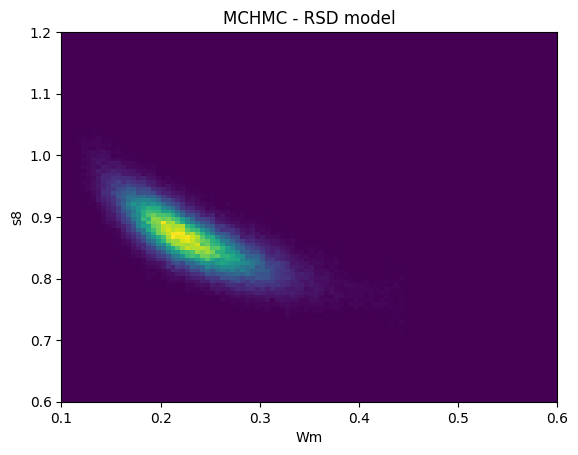

In [72]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [66]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

Initial Virial loss: 17717.306898678173
Virial loss: 106.93935735364268 --> Relative improvement: 0.9939641302165613
Virial loss: 91.53620623838985 --> Relative improvement: 0.14403631643601
Virial loss: 71.77670346311514 --> Relative improvement: 0.2158654327863947
Virial loss: 49.38582468471362 --> Relative improvement: 0.3119518966193233
Virial loss: 43.363281449882024 --> Relative improvement: 0.12194882384328698
Virial loss: 32.93340884135761 --> Relative improvement: 0.24052313984998908
Virial loss: 20.067724273427984 --> Relative improvement: 0.39065754261590324
Virial loss: 9.293223522462544 --> Relative improvement: 0.536906955874022
Virial loss: 8.798295311053053 --> Relative improvement: 0.053256893069794975
Virial loss: 6.961090856516447 --> Relative improvement: 0.20881368374036935


[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.4019513728906998
[ Info: Starting burn in ⏳


Virial loss: 6.387149837361451 --> Relative improvement: 0.08244986755455364
Virial loss: 3.1992163836164815 --> Relative improvement: 0.49911674767628644
Virial loss: 2.59413937477129 --> Relative improvement: 0.18913288014648
Virial loss: 2.4090341746912287 --> Relative improvement: 0.0713551484088557
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 0.23312387298025147
eps: 0.06155350123507378 --> VarE/d: 0.14128766584803643
eps: 0.0598440825101344 --> VarE/d: 0.15777668765608266
eps: 0.058330865993066944 --> VarE/d: 0.14949620295725086
eps: 0.05732411242579723 --> VarE/d: 0.1508859775202588
eps: 0.05649377416742363 --> VarE/d: 0.1664829476737934
eps: 0.05563100783806816 --> VarE/d: 0.1442479836253168
eps: 0.05509395681825664 --> VarE/d: 0.13543751534816412
eps: 0.05469995181313499 --> VarE/d: 0.14038069761014796
eps: 0.054303421495836376 --> VarE/d: 0.12972206917635845
eps: 0.05402575674829475 --> VarE/d: 0.12091332140090275
eps: 0.053838690280279336 --> VarE/d: 0.11104680

┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/Glamdring/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:247
[ Info: Found sigma: [0.9910366224850301, 0.13359046707555114] ✅
[ Info: Found eps: 0.054436291856389735 ✅
[ Info: Final nu 0.348762241004311


In [67]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

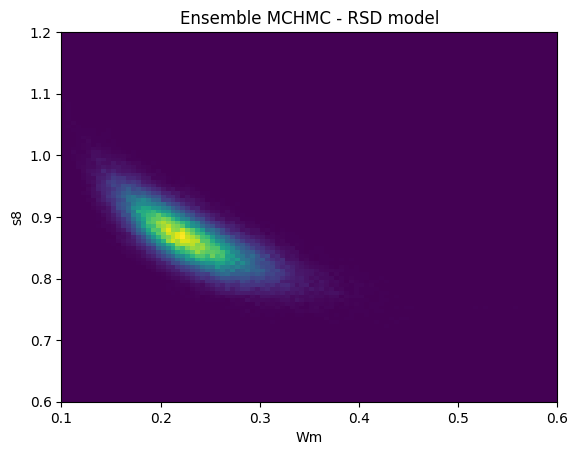

In [68]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [73]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

Using eps tuning method AdaptiveStep
eps: 0.5 --> VarE/d: 70227.71453800287
eps: 0.14888381480034726 --> VarE/d: 1554.5242321551216
eps: 0.07308521109045772 --> VarE/d: 31.26860308843237
eps: 0.05741727530516684 --> VarE/d: 0.7044575094078168
eps: 0.061284823847077056 --> VarE/d: 0.5413713232798919
eps: 0.06512303989870094 --> VarE/d: 0.158694922780946
eps: 0.0712759831337352 --> VarE/d: 0.3665838366407033
eps: 0.07519839537183115 --> VarE/d: 0.1584478040679127
eps: 0.08039159773716198 --> VarE/d: 1.9711618908949802
samples: 100--> 1/<1/ess>: 0.11921498951378807


[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.7169780267370375
[ Info: Found eps: 0.08039159773716198 ✅
[ Info: Found L: 0.26973654257752244 ✅
[ Info: Final nu 0.6383497889214209
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 2.52 seconds
Compute duration  = 2.52 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          Ωm    0.2206    0.0210     0.0002    0.0010     425.5490    1.0153   ⋯
          σ8    0.8701    0.0481     0.0005    0.0009   11436.7301    1.0025   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1813    0.2060    0.2202    0.2347    0.2632
          σ8    0.7811    0.8337    0.8702    0.9063    0.9626


In [74]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.89 seconds
Compute duration  = 0.89 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          Ωm    0.2209    0.0203     0.0002    0.0008     533.7129    1.0010   ⋯
          σ8    0.8692    0.0482     0.0005    0.0006   11403.5206    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1836    0.2067    0.2197    0.2347    0.2625
          σ8    0.7778    0.8328    0.8693    0.9046    0.9612


## Ensemble AbstractMCMC

In [75]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

LoadError: UndefVarError: `Burnin` not defined

In [76]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run


Chains MCMC chain (1000×4×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.3 seconds
Compute duration  = 0.3 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2203    0.0187     0.0006    0.0023     63.2322    0.9992    ⋯
          σ8    0.8696    0.0479     0.0015    0.0020   1171.5486    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1871    0.2071    0.2192    0.2327    0.2587
          σ8    0.7841    0.8324    0.8711    0.9039    0.9644


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [28]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

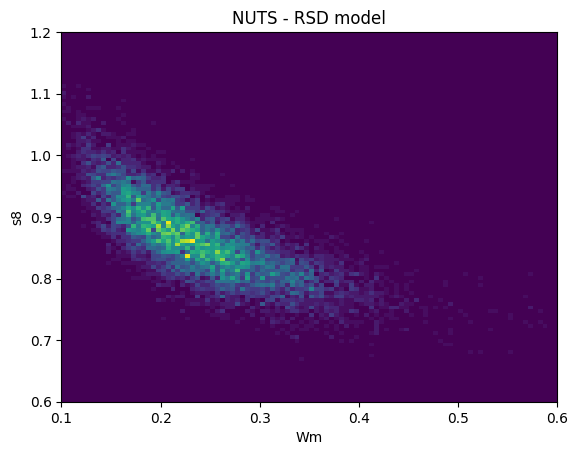

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");